# Deep Pensieve™
A Residual Multi-Stage Maximum Mean Discrepancy Variational Resize-Convolution Auto-Encoder with Group Normalization (RMSMMDVRCAECwGN)

## Imports

In [1]:
import time
import json
import random
import numpy as np
import tensorflow as tf

from libs import utils, gif
from libs.group_norm import GroupNormalization

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Flatten, Reshape, Add, Multiply, Activation, Lambda
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.objectives import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint, LambdaCallback

from keras import optimizers
from keras import backend as K

/home/mlacy/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Images

In [2]:
DIRECTORY = 'roadtrip'

SIZE = 256
CHANNELS = 3
FEATURES = SIZE*SIZE*CHANNELS

MODEL_NAME = DIRECTORY+'-'+str(SIZE)

In [3]:
# load images
imgs, xs, ys = utils.load_images(directory=DIRECTORY,rx=SIZE,ry=SIZE)

# normalize pixels
IMGS = imgs/127.5 - 1
FLAT = np.reshape(IMGS,(-1,SIZE*SIZE*CHANNELS))
SAMPLES =  np.random.permutation(FLAT)[:9]
TOTAL_BATCH = IMGS.shape[0]

# print shapes
print("MODEL: ",MODEL_NAME)
print("IMGS: ",IMGS.shape)
print("FLAT: ",FLAT.shape)
print("SAMPLES: ",SAMPLES.shape)

Loading images:	184
MODEL:  roadtrip-256
IMGS:  (184, 256, 256, 3)
FLAT:  (184, 196608)
SAMPLES:  (9, 196608)


## Utility Functions

In [4]:
def conv_gn_act(X,filters=None,kernel=None,stride=None,padding=None,activation=None):
    
    # convolution
    current_layer = Conv2D(filters,kernel,strides=stride,padding=padding,kernel_initializer=INITIALIZER)(X)  
    
    # group normalization
    current_layer = GroupNormalization(groups=filters,axis=-1)(current_layer)
    
    # activation
    current_layer = Activation(activation)(current_layer)
    
    return current_layer

## Maximum Mean Discrepancy 

In [5]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

## Encoder

In [6]:
def encode(x):
    # set current layer
    current_layer = Reshape((SIZE,SIZE,CHANNELS))(x)
    
    # convolutions
    for layer, n_filters in enumerate(FILTERS):

        # convolution + group norm + activation
        if(KERNELS[layer] == 5 and STRIDES[layer] == 1):
            current_layer = conv_gn_act(current_layer,n_filters,3,1,PADDING,ACTIVATION)
            current_layer = conv_gn_act(current_layer,n_filters,3,1,PADDING,ACTIVATION)
        else:
            current_layer = conv_gn_act(current_layer,n_filters,KERNELS[layer],STRIDES[layer],PADDING,ACTIVATION)

        # max pooling
        if(POOLING and KERNELS[layer] > 1):
            current_layer = MaxPooling2D()(current_layer)
    
    # grab the last shape for reconstruction
    shape = current_layer.get_shape().as_list()
    
    # flatten
    flat = Flatten()(current_layer)
    
    # latent vector
    z = Dense(LATENT_DIM)(flat)
    
    return z, (shape[1],shape[2],shape[3])

## Decoder

In [7]:
def decode(z,z_g,shape=None):
    
    # reverse the encoder
    filters = FILTERS[::-1]
    kernels = KERNELS[::-1]
    strides = STRIDES[::-1]

    # inflate
    inflated = shape[0]*shape[1]*shape[2]
    inflate = Dense(inflated)
    current_layer = inflate(z) ; generator = inflate(z_g)
    
    # reshape
    reshape = Reshape(shape)
    current_layer = reshape(current_layer)
    generator = reshape(generator)
    
    # build layers
    for layer, n_filters in enumerate(filters):
        
        # upsample
        if(POOLING and kernels[layer] > 1):
            u = UpSampling2D()
            current_layer = u(current_layer) ; generator = u(generator)

        # convolution
        if(KERNELS[layer] == 5 and STRIDES[layer] == 1):
            c1 = Conv2D(n_filters,3,strides=1,padding=PADDING,kernel_initializer=INITIALIZER)
            b1 = GroupNormalization(groups=n_filters,axis=-1)
            a1 = Activation(ACTIVATION)
            
            current_layer = c1(current_layer) ; generator = c1(generator)
            current_layer = b1(current_layer) ; generator = b1(generator)
            current_layer = a1(current_layer) ; generator = a1(generator)
            
            c2 = Conv2D(n_filters,3,strides=1,padding=PADDING,kernel_initializer=INITIALIZER)
            b2 = GroupNormalization(groups=n_filters,axis=-1)
            a2 = Activation(ACTIVATION)
            
            current_layer = c2(current_layer) ; generator = c2(generator)
            current_layer = b2(current_layer) ; generator = b2(generator)
            current_layer = a2(current_layer) ; generator = a2(generator)
            
        else:
            c = Conv2D(n_filters,kernels[layer],strides=strides[layer],padding=PADDING,kernel_initializer=INITIALIZER)
            b = GroupNormalization(groups=n_filters,axis=-1)
            a = Activation(ACTIVATION)
            
            current_layer = c(current_layer) ; generator = c(generator)
            current_layer = b(current_layer) ; generator = b(generator)
            current_layer = a(current_layer) ; generator = a(generator)
    
    # output
    output = Conv2D(CHANNELS,1,strides=1,padding=PADDING,activation='tanh')
    current_layer = output(current_layer) ; generator = output(generator)

    # flatten
    f = Flatten()
    current_layer = f(current_layer) ; generator = f(generator)
    
    return current_layer, generator

## Residual

In [8]:
def residual(x,x_g,is_first=False,is_last=False):
    
    # groups
    #groups = 3 if (x.shape[-1] == 3) else R_FILTERS
        
    # group norm + pre-activation
    #b0 = GroupNormalization(groups=groups,axis=-1)
    #a0 = Activation(ACTIVATION)
    
    #current_layer = b0(x) ; generator = b0(x_g)
    current_layer = x ; generator = x_g

    # shortcut
    shortcut = current_layer #if is_first else x
    shortcut_g = generator   #if is_first else x_g

    # conv 1
    c1 = Conv2D(R_FILTERS,R_KERNELS,strides=R_STRIDES,padding=PADDING,kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)
    
    # group norm 1
    #groups = 3 if (current_layer.shape[-1] == 3) else R_FILTERS
    #b1 = GroupNormalization(groups=groups,axis=-1)
    #current_layer = b1(current_layer) ; generator = b1(generator)
    
    # activation 1
    a1 = Activation(ACTIVATION)
    current_layer = a1(current_layer) ; generator = a1(generator)

    # conv 2
    c2 = Conv2D(R_FILTERS,R_KERNELS,strides=R_STRIDES,padding=PADDING,kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)

    # residual scaling
    current_layer = Lambda(lambda x: x * .1)(current_layer)
    generator = Lambda(lambda x: x * .1)(generator)

    # fix shortcut shape if mismatch
    if(shortcut.shape[-1] != current_layer.shape[-1]):
        s = Conv2D(R_FILTERS,1,strides=1,padding=PADDING,kernel_initializer=INITIALIZER)
        shortcut = s(current_layer) ; shortcut_g = s(generator)
        
    # merge shortcut
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])

    # if last one, group norm and activate
    #if (is_last):
        # groups
        #groups = 3 if (current_layer.shape[-1] == 3) else R_FILTERS
        #b2 = GroupNormalization(groups=groups,axis=-1)
        #a2 = Activation(ACTIVATION)
        
        #current_layer = b2(current_layer) ; generator = b2(generator)
        #current_layer = a2(current_layer) ; generator = a2(generator)

    return current_layer, generator

## Refiner

In [9]:
def refine(x,x_g):
    # reshape
    reshape = Reshape((SIZE,SIZE,CHANNELS))
    current_layer = reshape(x) ; generator = reshape(x_g)
    
    shortcut = current_layer #if is_first else x
    shortcut_g = generator   #if is_first else x_g
    
    # residual layers
    for layer in range(R_LAYERS):
        
        # handle shortcuts on first and last
        is_first = True if layer == 0 else False
        is_last = True if layer + 1 == R_LAYERS else False
        
        # residual block
        current_layer, generator = residual(current_layer,generator,is_first=is_first,is_last=is_last)
    
    # output convolution
    output = Conv2D(CHANNELS,1,strides=1,padding=PADDING,activation='tanh')
    current_layer = output(current_layer) ; generator = output(generator)
    
    # merge shortcut
    merge = Add()
    image = merge([current_layer, shortcut]) ; image_g = merge([generator, shortcut_g])
    
    return Flatten()(image), Flatten()(image_g)

## Callbacks

In [10]:
RECONS = []

def gifit(epoch=None):
    if (epoch % GIF_STEPS == 0):
        print('saving gif ...')
        [i,z,y] = AUTOENCODER.predict_on_batch(SAMPLES)
        img = np.clip(127.5*(i+1).reshape((-1, SIZE, SIZE, CHANNELS)), 0, 255)
        RECONS.append(utils.montage(img).astype(np.uint8))
        
def saveit(epoch=None):
    if (epoch == 0):
        print('saving model ...')
        with open(MODEL_NAME+'-model.json', 'w') as f:
            json.dump(AUTOENCODER.to_json(), f, ensure_ascii=False)
            
    if (epoch % MODEL_STEPS == 0):
        print('saving weights ...')
        AUTOENCODER.save_weights(MODEL_NAME+'-weights.h5')
        
        print('saving encoder ...')
        ENCODER.save(MODEL_NAME+'-encoder.hdf5')
        
        print('saving generator ...')
        GENERATOR.save(MODEL_NAME+'-generator.hdf5')

## Model

In [11]:
# Convolutions
FILTERS = [64,96,128,160,128,64]
KERNELS = [5,5,5,5,5,5]
STRIDES = [1,1,1,1,1,1]

# Residuals
R_LAYERS  = 16
R_FILTERS = 64
R_KERNELS = 3
R_STRIDES = 1
R_SCALING = .1

# Pooling and padding
POOLING = 'max'
PADDING = 'SAME'

# Default initializer and activation
INITIALIZER = 'he_normal'
ACTIVATION  = 'elu'

# Latent dimension size
LATENT_DIM = 1024

## Training

In [12]:
EPOCHS      = 8501
BATCH_SIZE  = 8

MODEL_STEPS = 50
GIF_STEPS   = 85

In [ ]:
# input
X = Input(shape=(FEATURES,))

# latent
Z, shape = encode(X)

# latent loss
epsilon = tf.random_normal(tf.stack([BATCH_SIZE, LATENT_DIM]))
latent_loss = compute_mmd(epsilon, Z)

# generator input
Z_G = Input(shape=(LATENT_DIM,))

# coarse reconstruction
Y, YG = decode(Z,Z_G,shape)
coarse_loss = mean_squared_error(X,Y)

# fine reconstruction
IMG, IMG_G = refine(Y,YG)
fine_loss = mean_absolute_error(X,IMG)

# define autoencoder
AUTOENCODER = Model(inputs=[X], outputs=[IMG,Z,Y])
AUTOENCODER.add_loss(latent_loss)
AUTOENCODER.add_loss(coarse_loss)
AUTOENCODER.add_loss(fine_loss)

# define encoder
ENCODER = Model(inputs=[X], outputs=[Z])

# define generator
GENERATOR = Model(inputs=[Z_G], outputs=[IMG_G])

# define optimizer
ADAM = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True)

# compile models
AUTOENCODER.compile(optimizer=ADAM)
ENCODER.compile(optimizer=ADAM,loss='mse')
GENERATOR.compile(optimizer=ADAM,loss='mse')

# print summary
AUTOENCODER.summary()

# callbacks
giffer = LambdaCallback(on_epoch_end=lambda epoch, logs: gifit(epoch))
saver = LambdaCallback(on_epoch_end=lambda epoch, logs: saveit(epoch))

# fit model
AUTOENCODER.fit(x=FLAT,batch_size=BATCH_SIZE,verbose=1,epochs=EPOCHS,shuffle=True,callbacks=[giffer,saver])

# save animated gif
gif.build_gif(RECONS, saveto=MODEL_NAME+'-final'+ "-"+str(time.time())+'.gif')

print("done")

/home/mlacy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "flatten_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "flatten_3" during training.
/home/mlacy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "dense_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_1" during training.
/home/mlacy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "flatten_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "flatten_2" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 196608)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        reshape_1[0][0]                  
__________________________________________________________________________________________________
group_normalization_1 (GroupNor (None, 256, 256, 64) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

Epoch 1/8501
184/184 [==============================] - 29s 156ms/step - loss: 1.1854
saving gif ...
saving model ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 2/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.6172
Epoch 3/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4827
Epoch 4/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4664
Epoch 5/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4409
Epoch 6/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4355
Epoch 7/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4229
Epoch 8/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4190
Epoch 9/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4066
Epoch 10/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.4037
Epoch 11/8501
184/184 [=========================

184/184 [==============================] - 20s 111ms/step - loss: 0.1828
Epoch 94/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1789
Epoch 95/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1773
Epoch 96/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1783
Epoch 97/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1786
Epoch 98/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1785
Epoch 99/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1793
Epoch 100/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1791
Epoch 101/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1783
saving weights ...
saving encoder ...
saving generator ...
Epoch 102/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1785
Epoch 103/8501
184/184 [==============================] - 21s 112ms/step - loss: 0

184/184 [==============================] - 21s 111ms/step - loss: 0.1455
Epoch 185/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1449
Epoch 186/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1430
Epoch 187/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1417
Epoch 188/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1408
Epoch 189/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1403
Epoch 190/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1407
Epoch 191/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1413
Epoch 192/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1425
Epoch 193/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1435
Epoch 194/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1428
Epoch 195/8501
184/184 [=======================

184/184 [==============================] - 21s 112ms/step - loss: 0.1279
Epoch 276/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.1303
Epoch 277/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1281
Epoch 278/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1269
Epoch 279/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1266
Epoch 280/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1248
Epoch 281/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1251
Epoch 282/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1258
Epoch 283/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1253
Epoch 284/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1232
Epoch 285/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1225
Epoch 286/8501
184/184 [=======================

184/184 [==============================] - 20s 111ms/step - loss: 0.1087
Epoch 367/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1079
Epoch 368/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1078
Epoch 369/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1096
Epoch 370/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.1093
Epoch 371/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1096
Epoch 372/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.1110
Epoch 373/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1106
Epoch 374/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1103
Epoch 375/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1106
Epoch 376/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1109
Epoch 377/8501
184/184 [=======================

184/184 [==============================] - 21s 112ms/step - loss: 0.0997
Epoch 458/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0999
Epoch 459/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1000
Epoch 460/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1000
Epoch 461/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1010
Epoch 462/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1012
Epoch 463/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.1000
Epoch 464/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1004
Epoch 465/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1003
Epoch 466/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.1011
Epoch 467/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0996
Epoch 468/8501
184/184 [=======================

184/184 [==============================] - 20s 111ms/step - loss: 0.0942
Epoch 550/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0950
Epoch 551/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0956
saving weights ...
saving encoder ...
saving generator ...
Epoch 552/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0951
Epoch 553/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0950
Epoch 554/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0946
Epoch 555/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0948
Epoch 556/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0947
Epoch 557/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0953
Epoch 558/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0941
Epoch 559/8501
184/184 [==============================] - 21s 111ms/step - l

184/184 [==============================] - 20s 111ms/step - loss: 0.0891
Epoch 641/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0891
Epoch 642/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0886
Epoch 643/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0898
Epoch 644/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0901
Epoch 645/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0900
Epoch 646/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0910
Epoch 647/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0908
Epoch 648/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0893
Epoch 649/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0883
Epoch 650/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0888
Epoch 651/8501
184/184 [=======================

184/184 [==============================] - 20s 111ms/step - loss: 0.0858
Epoch 732/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0858
Epoch 733/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0848
Epoch 734/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0849
Epoch 735/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0853
Epoch 736/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0850
Epoch 737/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0848
Epoch 738/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0860
Epoch 739/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0864
Epoch 740/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0858
Epoch 741/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0849
Epoch 742/8501
184/184 [=======================

184/184 [==============================] - 21s 112ms/step - loss: 0.0826
Epoch 823/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0827
Epoch 824/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0829
Epoch 825/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0830
Epoch 826/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0836
Epoch 827/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0832
Epoch 828/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0827
Epoch 829/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0828
Epoch 830/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0825
Epoch 831/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0815
Epoch 832/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0817
Epoch 833/8501
184/184 [=======================

184/184 [==============================] - 20s 111ms/step - loss: 0.0796
Epoch 914/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0797
Epoch 915/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0795
Epoch 916/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0794
Epoch 917/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0795
Epoch 918/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0802
Epoch 919/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0803
Epoch 920/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0799
Epoch 921/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0791
Epoch 922/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0788
Epoch 923/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0783
Epoch 924/8501
184/184 [=======================

184/184 [==============================] - 20s 111ms/step - loss: 0.0769
Epoch 1005/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0767
Epoch 1006/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0766
Epoch 1007/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0768
Epoch 1008/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0775
Epoch 1009/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0778
Epoch 1010/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0769
Epoch 1011/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0762
Epoch 1012/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0765
Epoch 1013/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0761
Epoch 1014/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0762
Epoch 1015/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0745
Epoch 1096/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0739
Epoch 1097/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0737
Epoch 1098/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0739
Epoch 1099/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0749
Epoch 1100/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0746
Epoch 1101/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0750
saving weights ...
saving encoder ...
saving generator ...
Epoch 1102/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0747
Epoch 1103/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0741
Epoch 1104/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0740
Epoch 1105/8501
184/184 [==============================] - 21s 112m

184/184 [==============================] - 20s 111ms/step - loss: 0.0729
Epoch 1186/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0724
Epoch 1187/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0721
Epoch 1188/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0720
Epoch 1189/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0718
Epoch 1190/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0717
Epoch 1191/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0716
saving gif ...
Epoch 1192/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0715
Epoch 1193/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0715
Epoch 1194/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0723
Epoch 1195/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0733
Epoch 1196/8501
184/18

184/184 [==============================] - 20s 111ms/step - loss: 0.0709
Epoch 1276/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0712
saving gif ...
Epoch 1277/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0712
Epoch 1278/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0715
Epoch 1279/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0721
Epoch 1280/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0723
Epoch 1281/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0716
Epoch 1282/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0711
Epoch 1283/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0704
Epoch 1284/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0703
Epoch 1285/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0707
Epoch 1286/8501
184/18

184/184 [==============================] - 20s 111ms/step - loss: 0.0699
Epoch 1366/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0705
Epoch 1367/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0710
Epoch 1368/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0702
Epoch 1369/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0698
Epoch 1370/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0693
Epoch 1371/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0693
Epoch 1372/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0691
Epoch 1373/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0688
Epoch 1374/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0691
Epoch 1375/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0689
Epoch 1376/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0681
Epoch 1456/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0682
Epoch 1457/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0691
Epoch 1458/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0690
Epoch 1459/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0686
Epoch 1460/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0678
Epoch 1461/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0672
Epoch 1462/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0676
Epoch 1463/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0677
Epoch 1464/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0681
Epoch 1465/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0683
Epoch 1466/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0671
Epoch 1547/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0669
Epoch 1548/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0664
Epoch 1549/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0659
Epoch 1550/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0659
Epoch 1551/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0660
saving weights ...
saving encoder ...
saving generator ...
Epoch 1552/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0665
Epoch 1553/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0664
Epoch 1554/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0663
Epoch 1555/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0663
Epoch 1556/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 20s 111ms/step - loss: 0.0646
Epoch 1637/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0643
Epoch 1638/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0644
Epoch 1639/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0644
Epoch 1640/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0646
Epoch 1641/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0653
Epoch 1642/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0657
Epoch 1643/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0655
Epoch 1644/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0650
Epoch 1645/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0654
Epoch 1646/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0652
Epoch 1647/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0647
Epoch 1727/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0651
Epoch 1728/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0646
Epoch 1729/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0643
Epoch 1730/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0644
Epoch 1731/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0639
Epoch 1732/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0639
Epoch 1733/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0647
Epoch 1734/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0652
Epoch 1735/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0651
Epoch 1736/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0647
Epoch 1737/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0644
Epoch 1817/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0641
Epoch 1818/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0633
Epoch 1819/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0627
Epoch 1820/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0625
Epoch 1821/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0628
Epoch 1822/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0635
Epoch 1823/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0637
Epoch 1824/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0632
Epoch 1825/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0629
Epoch 1826/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0636
Epoch 1827/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0621
Epoch 1907/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0624
Epoch 1908/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0625
Epoch 1909/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0630
Epoch 1910/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0624
Epoch 1911/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0620
Epoch 1912/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0620
Epoch 1913/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0623
Epoch 1914/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0625
Epoch 1915/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0623
Epoch 1916/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0625
Epoch 1917/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0604
Epoch 1998/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0607
Epoch 1999/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0610
Epoch 2000/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0615
Epoch 2001/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0614
saving weights ...
saving encoder ...
saving generator ...
Epoch 2002/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0615
Epoch 2003/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0622
Epoch 2004/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0625
Epoch 2005/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0620
Epoch 2006/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0624
Epoch 2007/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 20s 111ms/step - loss: 0.0610
Epoch 2088/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0625
Epoch 2089/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0621
Epoch 2090/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0620
Epoch 2091/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0613
Epoch 2092/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0610
Epoch 2093/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0605
Epoch 2094/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0600
Epoch 2095/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0598
Epoch 2096/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0597
Epoch 2097/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0601
Epoch 2098/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0603
Epoch 2178/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0601
Epoch 2179/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0601
Epoch 2180/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0601
Epoch 2181/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0598
Epoch 2182/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0598
Epoch 2183/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0600
Epoch 2184/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0602
Epoch 2185/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0610
Epoch 2186/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0608
Epoch 2187/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0602
Epoch 2188/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0601
Epoch 2268/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0603
Epoch 2269/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0598
Epoch 2270/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0594
Epoch 2271/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0595
Epoch 2272/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0594
Epoch 2273/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0592
Epoch 2274/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0590
Epoch 2275/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0589
Epoch 2276/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0591
Epoch 2277/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0594
Epoch 2278/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0580
Epoch 2358/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0577
Epoch 2359/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0577
Epoch 2360/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0580
Epoch 2361/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0583
Epoch 2362/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0585
Epoch 2363/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0585
Epoch 2364/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0582
Epoch 2365/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0584
Epoch 2366/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0588
Epoch 2367/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0586
Epoch 2368/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0578
Epoch 2449/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0575
Epoch 2450/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0574
Epoch 2451/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0573
saving weights ...
saving encoder ...
saving generator ...
Epoch 2452/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0572
Epoch 2453/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0573
Epoch 2454/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0574
Epoch 2455/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0573
Epoch 2456/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0574
Epoch 2457/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0575
Epoch 2458/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 20s 111ms/step - loss: 0.0569
Epoch 2539/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0567
Epoch 2540/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0567
Epoch 2541/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0566
Epoch 2542/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0567
Epoch 2543/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0567
Epoch 2544/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0570
Epoch 2545/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0569
Epoch 2546/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0570
Epoch 2547/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0577
Epoch 2548/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0582
Epoch 2549/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0562
Epoch 2629/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0565
Epoch 2630/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0562
Epoch 2631/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0561
Epoch 2632/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0560
Epoch 2633/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0565
Epoch 2634/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0565
Epoch 2635/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0562
Epoch 2636/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0561
saving gif ...
Epoch 2637/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0565
Epoch 2638/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0568
Epoch 2639/8501
184/18

184/184 [==============================] - 21s 111ms/step - loss: 0.0564
Epoch 2719/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0567
Epoch 2720/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0563
Epoch 2721/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0560
saving gif ...
Epoch 2722/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0558
Epoch 2723/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0555
Epoch 2724/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0559
Epoch 2725/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0559
Epoch 2726/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0560
Epoch 2727/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0566
Epoch 2728/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0561
Epoch 2729/8501
184/18

184/184 [==============================] - 21s 112ms/step - loss: 0.0551
Epoch 2809/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0552
Epoch 2810/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0549
Epoch 2811/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0549
Epoch 2812/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0549
Epoch 2813/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0551
Epoch 2814/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0552
Epoch 2815/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0555
Epoch 2816/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0553
Epoch 2817/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0550
Epoch 2818/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0551
Epoch 2819/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0552
Epoch 2900/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0558
Epoch 2901/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0553
saving weights ...
saving encoder ...
saving generator ...
Epoch 2902/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0551
Epoch 2903/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0553
Epoch 2904/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0559
Epoch 2905/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0557
Epoch 2906/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0552
Epoch 2907/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0549
Epoch 2908/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0550
Epoch 2909/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 21s 112ms/step - loss: 0.0548
Epoch 2990/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0551
Epoch 2991/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0548
Epoch 2992/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0549
Epoch 2993/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0556
Epoch 2994/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0553
Epoch 2995/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0552
Epoch 2996/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0550
Epoch 2997/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0545
Epoch 2998/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0544
Epoch 2999/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0543
Epoch 3000/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0540
Epoch 3080/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0544
Epoch 3081/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0540
Epoch 3082/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0542
Epoch 3083/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0545
Epoch 3084/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0547
Epoch 3085/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0547
Epoch 3086/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0543
Epoch 3087/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0540
Epoch 3088/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0540
Epoch 3089/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0541
Epoch 3090/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0528
Epoch 3170/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0529
Epoch 3171/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0529
Epoch 3172/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0528
Epoch 3173/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0529
Epoch 3174/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0530
Epoch 3175/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0531
Epoch 3176/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0532
Epoch 3177/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0534
Epoch 3178/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0540
Epoch 3179/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0541
Epoch 3180/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0535
Epoch 3260/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0538
Epoch 3261/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0538
Epoch 3262/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0536
Epoch 3263/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0530
Epoch 3264/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0528
Epoch 3265/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0529
Epoch 3266/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0532
Epoch 3267/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0534
Epoch 3268/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0530
Epoch 3269/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0533
Epoch 3270/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0520
Epoch 3351/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0524
saving weights ...
saving encoder ...
saving generator ...
Epoch 3352/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0526
Epoch 3353/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0527
Epoch 3354/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0528
Epoch 3355/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0529
Epoch 3356/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0527
Epoch 3357/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0528
Epoch 3358/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0526
Epoch 3359/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0523
Epoch 3360/8501
184/184 [==============================] - 21s 112m

184/184 [==============================] - 21s 112ms/step - loss: 0.0529
Epoch 3441/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0526
Epoch 3442/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0524
Epoch 3443/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0527
Epoch 3444/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0528
Epoch 3445/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0530
Epoch 3446/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0526
Epoch 3447/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0523
Epoch 3448/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0523
Epoch 3449/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0523
Epoch 3450/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0527
Epoch 3451/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0518
Epoch 3531/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0516
Epoch 3532/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0516
Epoch 3533/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0516
Epoch 3534/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0515
Epoch 3535/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0514
Epoch 3536/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0512
Epoch 3537/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0515
Epoch 3538/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0516
Epoch 3539/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0519
Epoch 3540/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0518
Epoch 3541/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0513
Epoch 3621/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0515
Epoch 3622/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0512
Epoch 3623/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0512
Epoch 3624/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0512
Epoch 3625/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0513
Epoch 3626/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0511
Epoch 3627/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0512
Epoch 3628/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0512
Epoch 3629/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0516
Epoch 3630/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0518
Epoch 3631/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0508
Epoch 3711/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0507
Epoch 3712/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0508
Epoch 3713/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0513
Epoch 3714/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0515
Epoch 3715/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0510
Epoch 3716/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0509
Epoch 3717/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0510
Epoch 3718/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0507
Epoch 3719/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0506
Epoch 3720/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0505
Epoch 3721/8501
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0513
saving weights ...
saving encoder ...
saving generator ...
Epoch 3802/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0513
Epoch 3803/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0518
Epoch 3804/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0519
Epoch 3805/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0519
Epoch 3806/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0521
Epoch 3807/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0523
Epoch 3808/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0524
Epoch 3809/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0520
Epoch 3810/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0520
Epoch 3811/8501
184/184 [==============================] - 21s 112m

184/184 [==============================] - 21s 112ms/step - loss: 0.0505
Epoch 3892/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0506
Epoch 3893/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0507
Epoch 3894/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0509
Epoch 3895/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0507
Epoch 3896/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0507
Epoch 3897/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0505
Epoch 3898/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0505
Epoch 3899/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0504
Epoch 3900/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0504
Epoch 3901/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0506
saving weights ...
saving encoder ...

184/184 [==============================] - 20s 111ms/step - loss: 0.0497
Epoch 3982/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0497
Epoch 3983/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0501
Epoch 3984/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0503
Epoch 3985/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0500
Epoch 3986/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0498
Epoch 3987/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0503
Epoch 3988/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0501
Epoch 3989/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0501
Epoch 3990/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0499
Epoch 3991/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0496
Epoch 3992/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0506
Epoch 4072/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0504
Epoch 4073/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0501
Epoch 4074/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0499
Epoch 4075/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0500
Epoch 4076/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0500
Epoch 4077/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0499
Epoch 4078/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0498
Epoch 4079/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0496
Epoch 4080/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0495
Epoch 4081/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0498
saving gif ...
Epoch 4082/8501
184/18

184/184 [==============================] - 20s 111ms/step - loss: 0.0490
Epoch 4162/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0491
Epoch 4163/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0494
Epoch 4164/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0494
Epoch 4165/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0494
Epoch 4166/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0496
saving gif ...
Epoch 4167/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0499
Epoch 4168/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0500
Epoch 4169/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0500
Epoch 4170/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0496
Epoch 4171/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0495
Epoch 4172/8501
184/18

saving generator ...
Epoch 4252/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0497
Epoch 4253/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0495
Epoch 4254/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0496
Epoch 4255/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0501
Epoch 4256/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0499
Epoch 4257/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0498
Epoch 4258/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0494
Epoch 4259/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0494
Epoch 4260/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0494
Epoch 4261/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0496
Epoch 4262/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0497


Epoch 4343/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0488
Epoch 4344/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0489
Epoch 4345/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0491
Epoch 4346/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0489
Epoch 4347/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0487
Epoch 4348/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0490
Epoch 4349/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0492
Epoch 4350/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0491
Epoch 4351/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0491
saving weights ...
saving encoder ...
saving generator ...
Epoch 4352/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0492
Epoch 4353/8501
184/184 [==========================

184/184 [==============================] - 20s 111ms/step - loss: 0.0486
Epoch 4434/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0489
Epoch 4435/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0488
Epoch 4436/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0488
Epoch 4437/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0486
Epoch 4438/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0485
Epoch 4439/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0484
Epoch 4440/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0483
Epoch 4441/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4442/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4443/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4444/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0488
Epoch 4524/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0484
Epoch 4525/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0483
Epoch 4526/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4527/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4528/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4529/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0483
Epoch 4530/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0484
Epoch 4531/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4532/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4533/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0485
Epoch 4534/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4614/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0479
Epoch 4615/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4616/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4617/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4618/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0484
Epoch 4619/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0485
Epoch 4620/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0484
Epoch 4621/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0487
Epoch 4622/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0486
Epoch 4623/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0484
Epoch 4624/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0477
Epoch 4704/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4705/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0479
Epoch 4706/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4707/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4708/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4709/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
Epoch 4710/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4711/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4712/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0479
Epoch 4713/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0484
Epoch 4714/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0478
Epoch 4795/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0475
Epoch 4796/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0474
Epoch 4797/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0478
Epoch 4798/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4799/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4800/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0482
Epoch 4801/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0481
saving weights ...
saving encoder ...
saving generator ...
Epoch 4802/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4803/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4804/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 21s 111ms/step - loss: 0.0482
Epoch 4885/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0480
Epoch 4886/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0476
Epoch 4887/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0474
Epoch 4888/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4889/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0470
Epoch 4890/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0471
Epoch 4891/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0469
Epoch 4892/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0468
Epoch 4893/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0470
Epoch 4894/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4895/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4975/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4976/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4977/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4978/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4979/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0474
Epoch 4980/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0474
Epoch 4981/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0472
Epoch 4982/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0472
Epoch 4983/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0472
Epoch 4984/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 4985/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0466
Epoch 5065/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0467
Epoch 5066/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0465
Epoch 5067/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0469
Epoch 5068/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0469
Epoch 5069/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0470
Epoch 5070/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0472
Epoch 5071/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0472
Epoch 5072/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0473
Epoch 5073/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0473
Epoch 5074/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0474
Epoch 5075/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5155/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0465
Epoch 5156/8501
184/184 [==============================] - 21s 112ms/step - loss: 0.0468
Epoch 5157/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0468
Epoch 5158/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0467
Epoch 5159/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0470
Epoch 5160/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0469
Epoch 5161/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 5162/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0472
Epoch 5163/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0468
Epoch 5164/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0469
Epoch 5165/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5246/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5247/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5248/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0467
Epoch 5249/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0468
Epoch 5250/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0467
Epoch 5251/8501
184/184 [==============================] - 21s 111ms/step - loss: 0.0468
saving weights ...
saving encoder ...
saving generator ...
Epoch 5252/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0471
Epoch 5253/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0470
Epoch 5254/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0470
Epoch 5255/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 20s 111ms/step - loss: 0.0464
Epoch 5336/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5337/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5338/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5339/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0461
Epoch 5340/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0460
Epoch 5341/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0461
Epoch 5342/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0463
Epoch 5343/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0464
Epoch 5344/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0465
Epoch 5345/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0465
Epoch 5346/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5426/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5427/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0462
Epoch 5428/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0461
Epoch 5429/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0460
Epoch 5430/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0464
Epoch 5431/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0463
Epoch 5432/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0463
Epoch 5433/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0461
Epoch 5434/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0460
Epoch 5435/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5436/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5516/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
Epoch 5517/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5518/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0458
Epoch 5519/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0460
Epoch 5520/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0461
Epoch 5521/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0463
Epoch 5522/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0463
Epoch 5523/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0463
Epoch 5524/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0461
Epoch 5525/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5526/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5606/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5607/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5608/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0460
Epoch 5609/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5610/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
Epoch 5611/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
saving gif ...
Epoch 5612/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0455
Epoch 5613/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5614/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5615/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5616/8501
184/18

184/184 [==============================] - 20s 111ms/step - loss: 0.0453
saving gif ...
Epoch 5697/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5698/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
Epoch 5699/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0458
Epoch 5700/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0458
Epoch 5701/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
saving weights ...
saving encoder ...
saving generator ...
Epoch 5702/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0460
Epoch 5703/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0459
Epoch 5704/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
Epoch 5705/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5706/8501
184/184 [===========================

184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5787/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0455
Epoch 5788/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5789/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5790/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0455
Epoch 5791/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5792/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0455
Epoch 5793/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
Epoch 5794/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0456
Epoch 5795/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0457
Epoch 5796/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0458
Epoch 5797/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0452
Epoch 5877/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0451
Epoch 5878/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0453
Epoch 5879/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0453
Epoch 5880/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0452
Epoch 5881/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0450
Epoch 5882/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0450
Epoch 5883/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0451
Epoch 5884/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0453
Epoch 5885/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0455
Epoch 5886/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0454
Epoch 5887/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0450
Epoch 5967/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0450
Epoch 5968/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0449
Epoch 5969/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
Epoch 5970/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0447
Epoch 5971/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
Epoch 5972/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0447
Epoch 5973/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0449
Epoch 5974/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0451
Epoch 5975/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0449
Epoch 5976/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0449
Epoch 5977/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0451
Epoch 6057/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6058/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
Epoch 6059/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0450
Epoch 6060/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0452
Epoch 6061/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0453
Epoch 6062/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0453
Epoch 6063/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0449
Epoch 6064/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0447
Epoch 6065/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
Epoch 6066/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0449
Epoch 6067/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6148/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
Epoch 6149/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0451
Epoch 6150/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0451
Epoch 6151/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
saving weights ...
saving encoder ...
saving generator ...
Epoch 6152/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6153/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0444
Epoch 6154/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0444
Epoch 6155/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6156/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6157/8501
184/184 [==============================] - 20s 111m

184/184 [==============================] - 20s 111ms/step - loss: 0.0443
Epoch 6238/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0444
Epoch 6239/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0447
Epoch 6240/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0444
Epoch 6241/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0443
Epoch 6242/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6243/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0445
Epoch 6244/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0445
Epoch 6245/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0447
Epoch 6246/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0445
Epoch 6247/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0445
Epoch 6248/8501
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.0450
Epoch 6328/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0448
Epoch 6329/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6330/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0446
Epoch 6331/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0443
Epoch 6332/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0443
Epoch 6333/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0443
Epoch 6334/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0441
Epoch 6335/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0442
Epoch 6336/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0441
Epoch 6337/8501
184/184 [==============================] - 20s 111ms/step - loss: 0.0444
Epoch 6338/8501
184/184 [============

## Load Models

In [18]:
print('loading encoder ...')
ENCODER = load_model(MODEL_NAME+'-encoder.hdf5')

print('loading generator ...')
GENERATOR = load_model(MODEL_NAME+'-generator.hdf5')

print('done')

loading encoder ...


/home/mlacy/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


loading generator ...
done


## Reconstruction 

In [19]:
def reconstruct(index=0):
    x = np.reshape(FLAT[index],(-1,FEATURES))
    z = np.reshape(ENCODER.predict_on_batch(x),(-1,LATENT_DIM))
    y = np.reshape(GENERATOR.predict_on_batch(z),(-1,FEATURES))
    
    t = IMGS[index]/2 + .5
    img = np.reshape(y[0]/2 + .5,(SIZE,SIZE,CHANNELS))
    
    print("PSNR: %.3f" % utils.psnr(t,img))
    print("MS-SSIM: %.3f" % utils.MultiScaleSSIM(np.reshape(t,(1,SIZE,SIZE,CHANNELS)),
                                                 np.reshape(img,(1,SIZE,SIZE,CHANNELS)),
                                                 max_val=1.))
    
   
    return t, img

171
PSNR: 18.434
MS-SSIM: 0.469


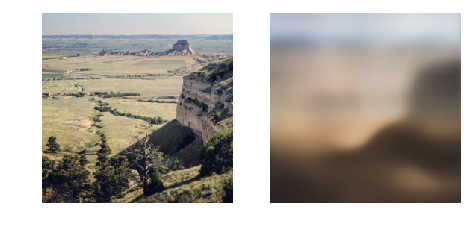

In [20]:
r = random.randint(0,TOTAL_BATCH) ; print(r)
orig, img = reconstruct(r)
utils.showImagesHorizontally(images=[orig,img])

## Latent  Animation

In [21]:
def random_latents(n_imgs=3,path='linear',steps=30,directory='roadtrip'):
    imgs = np.random.permutation(FLAT)[:n_imgs]
    latent_animation(imgs,steps,path=path)

def latent_animation(imgs=None,steps=None,path=None,filename="latent-animation-"):
    # get encodings
    print('getting latent vectors ...')
    latents = []
    for index,img in enumerate(imgs):
        img = np.reshape(img,(-1,FEATURES))
        latent = ENCODER.predict_on_batch(img)
        latents.append(latent)

    # calculate latent transitions
    print('calculating latent manifold path ...')
    recons = []
    current_step = None
    for i in range(len(latents)-1):
        l1 = latents[i]
        l2 = latents[i+1]

        # latent image distance
        image_distance = l2 - l1

        # sine wave for animation steps
        integral = steps*(1+np.cos(np.pi/steps))/np.pi
        normalizer = image_distance/integral

        # start image
        current_step = l1
        
        # build latent vectors to animate transition
        recons.append(l1)
        for i in range(steps):
            if (path == 'contract'):
                current_step = current_step + normalizer*np.sin(np.pi*i/steps)
            else: # linear
                current_step = l1 + i*image_distance/steps

            recons.append(current_step)
        recons.append(l2)
    
    # get predictions from latent vectors
    print('reconstructing ... ')
    recons = np.reshape(recons,(-1,LATENT_DIM))
    i = GENERATOR.predict_on_batch(recons)

    # de-normalize and clip the output
    final = np.clip((127.5*(i+1)).reshape((-1,SIZE,SIZE,CHANNELS)),0,255)

    # build the gif
    filename = filename+str(time.time())
    gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+"-final.gif",dpi=SIZE)

    print(filename)


getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525653141.5591424


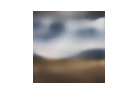

In [22]:
random_latents(n_imgs=3,steps=50)

In [ ]:
imgs =  np.random.permutation(FLAT)
for i in range(TOTAL_BATCH):
    print(i)
    latent_animation([imgs[i],imgs[i+1]],150)
    